# Library imports and kernel setup

Computation:

All computations were performed using numpy or python itself.
Scientific constants were taken from scipy's package scipy.constants.

Graphics:

For this notebook, a series of interactive displays and graphics were used.
These included matplotlib's 3d and 2d plots [blue_text](https://matplotlib.org/),
as well as PyVista for mesh rendering [blue_text](https://www.pyvista.org/).
In addition to these external libraries, for some interactive components such as sliders,
as well as display components such as labels, Jupyter's IPython related packages were used
[blue_text](https://ipython.org/), [blue_text](https://jupyter.org/)

In [1]:
%matplotlib notebook
%matplotlib notebook

import numpy as np
import scipy.constants as consts
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import pyvista as pv

# Introduction to coaxial cables

For the purposes of this notebook, a length of a coaxial cable will be considered.
This length will be characterized by 3 parameters:
- Inner conductor's radius: $a$
- Outer conductor's radius: $b$
- length of cable: $h$

An interactive viewport of how these parameters affect the cable is shown below.

Within this cell, a set of global variables is created including
the parameters discussed above, and some variables which will be used for rendering
the coaxial cable later.  Additionally, a set of IPython sliders is created to allow
for the user to easily select the values he/she would like.

The "create_surf" function initializes "surf" with a mesh of the coaxial cable defined by
"params" that PyVista will be able to render in a later cell.  Additionally, the
"update_display" function is setup as an event handler for the sliders, recreating
surf for every change to the parameters.

In [2]:
params = [0.1, 1.0, 5.0] # inner radius a, outer radius b, cable length h
render_face_num = 100    # number of faces to display on the cable render
surf = None              # pyvista mesh


coax_widgets = (
    widgets.FloatSlider(min=0.01, max=10.0, step=0.01, value=params[0],
                        description="Inner radius 'a'"),
    widgets.FloatSlider(min=0.01, max=10.0, step=0.01, value=params[1],
                        description="Outer radius 'b'"),
    widgets.FloatSlider(min=0,    max=10.0, step=0.01, value=params[2],
                        description="Cable length 'h'")
)


def create_surf():
    """
    Initializes the global surf with a mesh that describes the coax cable
    """
    # the global variable surf will be initialized by this function
    global surf

    # compute circle coordinate for a series of theta values, and 2 radii
    theta_values = np.linspace(0, 2 * np.pi, render_face_num+1)[:-1]
    x = np.cos(theta_values).reshape(1, -1)
    y = np.sin(theta_values).reshape(1, -1)
    x_arr, y_arr = [], []
    for i in [0, 1]:
        x_arr.append(x.copy() * params[i])
        y_arr.append(y.copy() * params[i])

    # generating the cylinder's vertices
    pts = np.concatenate(
        (
            np.concatenate((x_arr[0], y_arr[0], np.zeros((1, render_face_num)))),
            np.concatenate((x_arr[0], y_arr[0], np.full((1, render_face_num), params[2]))),
            np.concatenate((x_arr[1], y_arr[1], np.zeros((1, render_face_num)))),
            np.concatenate((x_arr[1], y_arr[1], np.full((1, render_face_num), params[2])))
        ), 1
    )

    # building the edges of the cylinders
    faces = []
    for i in range(render_face_num):
        j = (i+1) % render_face_num
        faces.append(np.array([4, i, j, j + render_face_num, i + render_face_num]))
        faces.append(np.array([4, i + 2 * render_face_num, j + 2 * render_face_num,
                               j + 3 * render_face_num, i + 3 * render_face_num]))

    # front and back faces of the inner conductor
    faces.append([100] + [i for i in range(0  , 100)])
    faces.append([100] + [i for i in range(100, 200)])
    faces = np.hstack(faces)
    surf = pv.PolyData(pts.transpose(), faces)


def update_display(change):
    """
    Event handler for each of the sliders
    """
    global plotter
    if change.name == "value":
        params[change.owner.local_id] = change.new
        create_surf()   # regenerate the surface on each update (not optimized code)

# setting the event handler for each of the sliders, and displaying them
for i, e in enumerate(coax_widgets):
    e.local_id = i
    e.observe(update_display)
    display(e)

FloatSlider(value=0.1, description="Inner radius 'a'", max=10.0, min=0.01, step=0.01)

FloatSlider(value=1.0, description="Outer radius 'b'", max=10.0, min=0.01, step=0.01)

FloatSlider(value=5.0, description="Cable length 'h'", max=10.0, step=0.01)

The cell below run the code necessary to render render surf in an interactive viewport
using PyVista.  It is worth noting that the pipeline used to render the cable is not
optimized, but this shouldn't effect the speed too drastically.

If you have change the parameters above using the sliders, you will need to re-run
this cell to view how the parameters would effect the cable's appearance.

In [3]:
if params[1] <= params[0]:  # this line is equivalent to - if b <= a
    raise ValueError("Invalid parameter selection:\n\tThe inner radius must be strictly less than the outer")

# plotting the coaxial cable in pyvista
plotter = pv.PlotterITK()
create_surf()
plotter.add_mesh(surf)
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Inductance and capacitance of the coaxial cable

The cell below provides a series of functions which can be used to determine the
inductance(s) and capacitance of any straight length of coaxial cable.  The formulas
used were derived in the report, and were merely implemented here.  The exact
functions are as follows:

$L_{in} = \frac{\mu h}{8\pi}$

$L_{ext} = \frac{\mu_0h}{2\pi}ln\left(\frac{b}{a}\right)$

$L = L_{in} + L_{ext} = \frac{h}{2\pi}\left(\frac{\mu}{4} + \mu_0ln\left(\frac{b}{a}\right)\right)$

$C=\frac{2\pi h\varepsilon_0}{ln\left(\frac{b}{a}\right)}$

Additionally, all of these functions were implemented in such a way that the functions
would be able to handle point-wise computation if provided with data in the form of
some tensor.  Details can be found in the function's respective docstrings.

In [4]:
def internal_inductance(h):
    """
    Calculates the internal inductance based on on values given
    Note: the operation is performed point-wise on the given data
          mu_0 was used for permeability as the true value was not given
    :param h: the length of the coaxial cable in meters
    :return: the internal self inductance of the cable in Henrys
    """
    return (consts.mu_0 * h) / (8 * np.pi)

def external_inductance(a, b, h):
    """
    Calculates the external inductance based on on values given
    Note: the operation is performed point-wise on the given data
    :param a: the radius of the inner conductor in meters
    :param b: the radius of the outer conductor in meters
    :param h: the length of the coaxial cable in meters
    :return: the external self inductance of the cable in Henrys
    """
    return (consts.mu_0 * h) / (2 * np.pi) * np.log(b / a)

def total_inductance(a, b, h):
    """
    Calculates the total inductance based on on values given
    Note: the operation is performed point-wise on the given data
    :param a: the radius of the inner conductor in meters
    :param b: the radius of the outer conductor in meters
    :param h: the length of the coaxial cable in meters
    :return: the self inductance of the cable in Henrys
    """
    return internal_inductance(h) + external_inductance(a, b, h)

def capacitance(a, b, h):
    """
    Calculates the capacitance based on values given
    Note: the operation is performed point-wise on the given data
    :param a: the radius of the inner conductor in meters
    :param b: the radius of the outer conductor in meters
    :param h: the length of the coaxial cable in meters
    :return: the capacitance between the two conductors in Farads
    """
    return (2 * np.pi * h * consts.epsilon_0) / np.log(b / a)

Using the functions defined in the previous cell alongside IPython Labels, each of
the attributes of the coaxial cable are calculated and displayed.
The parameters used to define the coaxial cable were taken from the sliders generated above.

In [5]:
if params[1] <= params[0]:  # this line is equivalent to - if b <= a
    raise ValueError("Invalid parameter selection:\n\tThe inner radius must be strictly less than the outer")

# creating the label objects
lbl_Lin = widgets.Label("Internal inductance:  {}".format(internal_inductance(params[2])))
lbl_Lext = widgets.Label("External inductance: {}".format(external_inductance(*params)))
lbl_Ltot = widgets.Label("Total inductance:    {}".format(total_inductance(*params)))
lbl_C = widgets.Label("Capacitance:            {}".format(capacitance(*params)))

# displaying each of the labels
display(lbl_Lin)
display(lbl_Lext)
display(lbl_Ltot)
display(lbl_C)

Label(value='Internal inductance:  2.5000000000000004e-07')

Label(value='External inductance: 2.3025850929940464e-06')

Label(value='Total inductance:    2.5525850929940466e-06')

Label(value='Capacitance:            1.2080444490835755e-10')

Analysing the functions presented above, the a and b parameters are always found connected by
division.  With that, a plot of the external self inductance vs $\frac{b}{a}$ was created in addition
to a plot of capacitance vs $\frac{b}{a}$.

At the beginning of the cell below, a series of hyper-parameters were declared which defined how
the plots would appear, and the location of their save on disk for future use.

"data_point_num" defines the number of samples taken from the curves for display, at 100 samples,
the curve will appear continuous, but if needed, this parameter can be set to produce any number
of samples.

"min_b" and "max_b" define the range of $\frac{b}{a}$ value over which both the capacitance and inductance
were calculated.  The values of these were provided by the instructor.

"plot_dir" is a string which defines the path that both figures will be saved to.

Making use of notebook cells, neither plot is created by this cell, only the setup is provided.
The function calls which perform this have independent cells.

Note that by setting the a argument as 1 allowed for the b parameter to solely determine the
$\frac{b}{a}$ value computed.  Additionally, setting the h argument as 1 can be interpreted in 2
different ways. The first of which is that these plots consider a 1m length of coaxial cable.
The second is a direct result of the equation above being linearly proportional to the length of
cable.  This implies that computing these values for a length of 1 is equivalent to computing the
inductance/capacitance of the conductor per unit of length.

In [6]:
# plot hyperparameters
data_point_num = 100
min_b, max_b = 1.1, 10
plot_dir = "./plots/"

# generating the values which will be used for plotting
b = np.linspace(min_b, max_b, data_point_num)
L_ext = external_inductance(1, b, 1)    # getting L_ext for all b
C = capacitance(1, b, 1)                # getting C     for all b

def create_plot(x, y, xlabel, ylabel, title=None, c=(0, 0, 0), name=None):
    """
    wrapper for plt.plot,
    plots a 2d graph
    :param name: the name of the file to save to.  If None => don't save
    """
    fig = plt.figure()

    plt.plot(x, y, c=c)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title is not None:
        plt.suptitle(title)

    if name is not None:
        fig.savefig("{}{}".format(plot_dir, name))

This cell makes use of the above function "create_plot" to generate a plot of
$L_{ext}$ vs. $\frac{b}{a}$

<IPython.core.display.Javascript object>


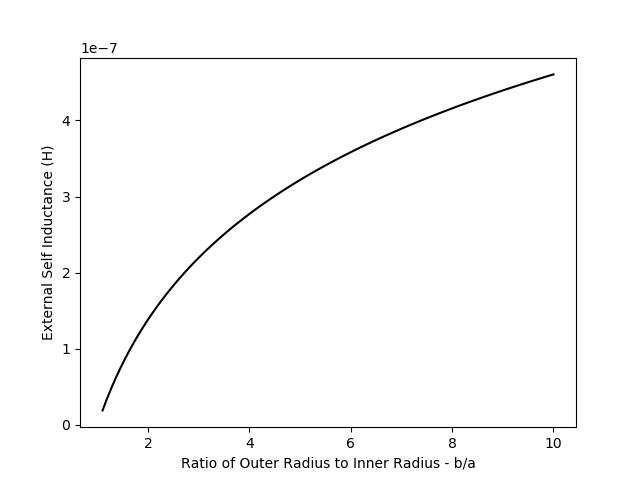

In [7]:
create_plot(b, L_ext,
            "Ratio of Outer Radius to Inner Radius - b/a",
            "External Self Inductance (H)",
            name="L_ext.png")

This cell makes use of the above function "create_plot" to generate a plot of
$C$ vs. $\frac{b}{a}$

<IPython.core.display.Javascript object>


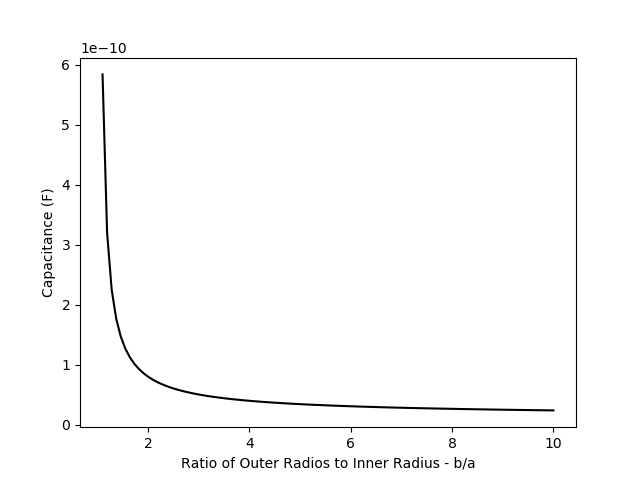

In [8]:
create_plot(b, C,
            "Ratio of Outer Radios to Inner Radius - b/a",
            "Capacitance (F)",
            name="C.png")

Computing $L_{ext}C(\frac{b}{a}, h)$

$L_{ext}C = \mu_0\varepsilon_0h^2$

In [9]:
# plot hyperparameters
# x => b/a , y => h
x_point_num = 10
y_point_num = 10
min_b, max_b = 1.1, 10
min_h, max_h = 0,   10

# generating the values which will be used for plotting
x = np.linspace(min_b, max_b, x_point_num)
y = np.linspace(min_h, max_h, y_point_num)

# creating a grid of (b/a, h) pair - outer product of b and h, but with tuples
bh_pairs = np.empty((x_point_num, y_point_num, 2), dtype=np.float32)
bh_pairs[:, :, 0] = x
bh_pairs[:, :, 1] = y

# computing the inductance and capacitance for each
bh_trans = np.transpose(bh_pairs, (2, 0, 1))
z = external_inductance(1, bh_trans[0], bh_trans[1]) *\
    capacitance(        1, bh_trans[0], bh_trans[1])
x, y = np.meshgrid(x, y)

Plotting $L_{ext}C(\frac{b}{a}, h)$

<IPython.core.display.Javascript object>


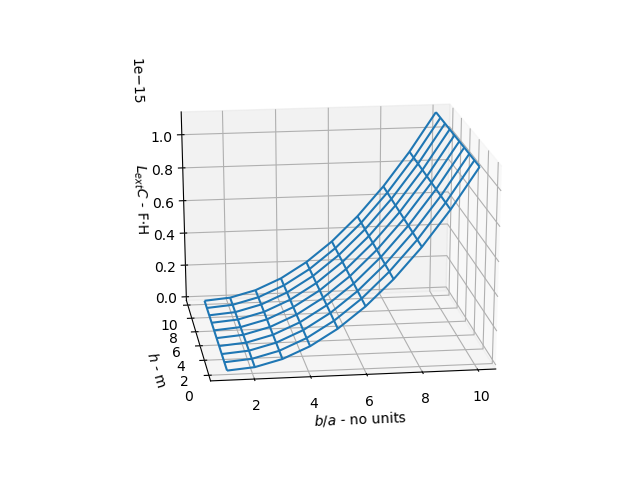

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("$b/a$ - no units")
ax.set_ylabel("$h$ - m")
ax.set_zlabel("$L_{ext}C$ - F$\cdot$H")
ax.plot_wireframe(x, y, z)

fig.savefig("./plots/LC-bh.png")

Although $L_{ext}C$ is dependant on $h$, according to the equation stated above,
this equation simplifies to the equation below following for h = 1.

$L_{ext}C = \mu_0\varepsilon_0$

Allowing for simple calculation of the product $\mu_0\varepsilon_0$.
The calculation of this value is found in the cell below.

In [11]:
# using the previously calculated L_ext and C values over a range of b/a, then finding the mean
mu_epsilon = np.mean(L_ext*C)

The calculated $\mu_0\varepsilon_0$ value can be easily compared to the known values
through use of scipy's constant package.  This calculation is shown in the following
cell.

In [12]:
true_val = consts.mu_0 * consts.epsilon_0
error = 100 * (mu_epsilon - true_val) / true_val
lbl_expval = widgets.Label("Calculated value for $\mu_0\\varepsilon_0$: {}".format(mu_epsilon))
lbl_trueval = widgets.Label("True value for $\mu_0\\varepsilon_0$: {}".format(true_val))
lbl_err = widgets.Label("Percent error of calculated value: {}%".format(error))
display(lbl_expval)
display(lbl_trueval)
display(lbl_err)

Label(value='Calculated value for $\\mu_0\\varepsilon_0$: 1.1126500560536188e-17')

Label(value='True value for $\\mu_0\\varepsilon_0$: 1.1126500560536183e-17')

Label(value='Percent error of calculated value: 4.154254827365615e-14%')